# Simulacion Pelicano

* [sim_cell](#sim_cell)
* [control](#control_cell)
* [test_cell](#test_cell)





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import signal

Matriz de transformacion $R_b^i$


$$ [x^{(1)} y^{(1)}z^{(1)}]^T=R_b^i(\phi,\theta,\psi) [u v w]$$

con


$$ R_b^i(\phi,\theta,\psi) = \begin{bmatrix}
cos(\theta)cos(\psi) &  sin(\phi)sin(\theta)cos(\psi)-cos(\phi)sin(\psi) & cos(\phi)sin(\theta)cos(\psi)+sin(\phi)sin(\psi) \\
cos(\theta)sin(\psi) &  sin(\phi)sin(\theta)sin(\psi)+cos(\phi)cos(\psi) & cos(\phi)sin(\theta)sin(\psi)-sin(\phi)cos(\psi) \\
-sin(\theta)         &          sin(\phi)cos(\theta)&                                     cos(\phi)cos(\theta)
\end{bmatrix}$$

In [2]:
# matriz transformacion
# [x_dot y_dot z_dot]^T = R_b_i [u v w]^T
#
def get_R_b_i(phi, theta, psi):
    return [
        [np.cos(theta)*np.cos(psi),  np.sin(phi)*np.sin(theta)*np.cos(psi)-np.cos(phi)*np.sin(psi), np.cos(phi)*np.sin(theta)*np.cos(psi)+np.sin(phi)*np.sin(psi)],
        [np.cos(theta)*np.sin(psi),  np.sin(phi)*np.sin(theta)*np.sin(psi)+np.cos(phi)*np.cos(psi), np.cos(phi)*np.sin(theta)*np.sin(psi)-np.sin(phi)*np.cos(psi)],
        [-np.sin(theta),          np.sin(phi)*np.cos(theta),                                     np.cos(phi)*np.cos(theta)]]


In [3]:
# estado: se trata de una estructura
class state_class:
    x =0
    y= 0
    z = 0
        
    phi = 0;
    theta = 0;
    psi = 0;
    
    u = 0
    v = 0
    w = 0
    
    p = 0
    q = 0
    r = 0

    def reset(self):
        self.x = 0
        self.y = 0
        self.z = 0
        
        self.phi = 0
        self.theta = 0
        self.psi = 0
        
        self.u = 0
        self.v = 0
        self.w = 0
        
        self.p = 0
        self.q = 0
        self.r = 0
        
    def __init__(self):
        self.reset()
        
    def get(self):
        return self.x, self.y, self.z, \
    self.u, self.v, self.w, \
    self.phi, self.theta, self.psi, \
    self.p, self.q, self.r
     


In [4]:
class helo_model_class:
    kplat = 0.010270019155209309
    kplon = -0.005451590220066471
    kpp1 = 1.6000649499575583
    kpp2 = -0.6024512171373023
    kpq1 = -0.07838208574305183
    kpq2 = 0.07218587842107016

    kqq1 =  0.49424047246691166
    kqq2 = 0.48747950040347793
    kqlat = 0.019859818630942216
    kqlon = -0.04408244668434985
  
    K_ped =  1.886918594924818
    Z_col =  -0.27267421
    
    state      = state_class ()
    state_prev = state_class ()
    state_prev2 = state_class ()
    
    def __init__(self):
        self.state.reset()
        self.state_prev.reset()
        self.state_prev2.reset()
        
        pass

    def step(self, d_lat, d_lon, d_col, d_ped):

        g = 9.8

        # guarda prev
        self.state_prev2 = self.state_prev
        self.state_prev = self.state
        
        # actualiza estado
        self.state.p = self.kpp1 * self.state_prev.p +  self.kpp2 * self.state_prev2.p \
        + self.kpq1 * self.state_prev.q +  self.kpq2 * self.state_prev2.q \
        + self.kplat * d_lat + self.kplon * d_lon
        
        self.state.q = self.kqq1 * self.state_prev.q +  self.kqq2 * self.state_prev2.q \
        + self.kqlat * d_lat + self.kqlon * d_lon
        
        self.state.r = self.K_ped * d_ped
        
        self.state.u = self.state_prev.u - g*self.state_prev.theta*Ts
        self.state.v = self.state_prev.v + g*self.state_prev.phi*Ts
        self.state.w = self.state_prev.w + self.Z_col*d_col
        
        phi   = self.state_prev.phi
        theta = self.state_prev.theta
        psi   = self.state_prev.psi

        G = np.array([[1,np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
                      [0,np.cos(phi),              -np.sin(phi)],
                      [0,np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])
        phi_theta_psi = np.matmul(G, [self.state_prev.p,self.state_prev.q,self.state_prev.r])
        
        self.state.phi   = self.state_prev.phi   +  Ts*phi_theta_psi[0]
        self.state.theta = self.state_prev.theta +  Ts*phi_theta_psi[1]
        self.state.psi   = self.state_prev.psi   +  Ts*phi_theta_psi[2]
        
        R_b_i = get_R_b_i(phi, theta, psi)
        uvw = [self.state_prev.u, self.state_prev.v, self.state_prev.w]
        xyz_dot = np.matmul(R_b_i,uvw)
        x_dot = xyz_dot[0]
        y_dot = xyz_dot[1]
        z_dot = xyz_dot[2]
        
        self.state.x = self.state_prev.x + Ts*x_dot
        self.state.y = self.state_prev.y + Ts*y_dot
        self.state.z = self.state_prev.z + Ts*z_dot
        
        return self.state

## pid

In [5]:
#pid
class pid_class:
    def __init__(self):
        self.I = 0 # integral

    def step(self, e, e_dot):
        self.I = self.I + e*Ts
        p0 = .01
        lambda_0 = p0**3
        lambda_1 = 3*p0**2
        lambda_2 = 3*p0
        return -lambda_0*self.I - lambda_1*e - lambda_2*e_dot

## control
<a id='control_cell'></a>

In [6]:
# control        
class control_class:
    def __init__(self, helo_model):
        self.helo_model = helo_model
        self.pid_z = pid_class() # pid
        pass

    def p_q(self, p_ref, q_ref):
        d_lat = -5*(self.helo_model.state_prev.p-p_ref)
        d_lon =  5*(self.helo_model.state_prev.q-q_ref)
        return d_lat,d_lon

    def phi_theta(self, phi_ref, theta_ref):
        p_ref = -(self.helo_model.state_prev.phi-phi_ref)*0.9      
        q_ref = -(self.helo_model.state_prev.theta-theta_ref)*0.9
        return self.p_q(p_ref, q_ref)

    def u_v(self, u_ref, v_ref):
        theta_ref    =   (self.helo_model.state_prev.u-u_ref)/9.8/Ts * 0.005
        phi_ref      =  -(self.helo_model.state_prev.v-v_ref)/9.8/Ts * 0.005
        return self.phi_theta(phi_ref, theta_ref)

    def w(self, w_ref):
        e = self.helo_model.state_prev.w - w_ref
        d_col = e*(1-0.9)
        return d_col;

    def z(self, z_ref, N=10):
        e = self.helo_model.state_prev.z - z_ref;
        w = self.helo_model.state_prev.w 
        d_col = -(e + Ts*w)*(1/N)
        d_col = d_col /Ts-w
        d_col = d_col / self.helo_model.Z_col
        return d_col

    def psi(self, psi_ref):
        e = self.helo_model.state_prev.psi - psi_ref;
        d_ped = -e*(1-0.91)
        return d_ped


# Test
<a id='test_cell'></a>

In [26]:
# test:
# z, psi
class test_class:
    N =0
    ind = 0
    def __init__(self):
#        self.info=(t, u, v, z, psi)
        self.info=( (0, 0, 0, 0, 0),
                    (10, 1, 0, .10,  np.pi/2),
                    (100, 2, 0, .10,  np.pi/2),
                    (200, 2, 0, -.1, -np.pi/2),
                    (400, 2, 0, -.1, -np.pi/2*0)
                  )
        self.N = len(self.info)
        self.ind = 0

    def get(self, t_sim):
        ind = self.ind
        if (ind+1)<self.N:
            t = self.info[ind+1][0]
            if t<= t_sim:
                self.ind = self.ind + 1
        u   = self.info[self.ind][1]
        v   = self.info[self.ind][2]
        z   = self.info[self.ind][3]
        psi = self.info[self.ind][4]
        return u, v, z, psi

# Simulation
<a id='sim_cell'></a>

In [35]:
helo_model = helo_model_class()
control = control_class(helo_model)
test = test_class()

N = 30000
Ts = 0.01
d_lat = np.zeros(N)
d_lon = np.zeros(N)
d_col = np.zeros(N)
d_ped = np.zeros(N)

x = np.zeros(N)
y = np.zeros(N)
z = np.zeros(N)

u = np.zeros(N)
v = np.zeros(N)
w = np.zeros(N)
phi = np.zeros(N)
theta = np.zeros(N)
psi = np.zeros(N)

p = np.zeros(N)
q = np.zeros(N)
r = np.zeros(N)

p_ref = np.zeros(N)
q_ref = np.zeros(N)
u_ref = np.zeros(N)
v_ref = np.zeros(N)
z_ref = np.zeros(N)
psi_ref = np.zeros(N)

# simulacion
for k in range(0,N):   
    # referencia
    u_ref[k], v_ref[k], z_ref[k], psi_ref[k] = test.get(k*Ts)
    
    ## control
    d_lat[k], d_lon[k] = control.u_v(u_ref[k], v_ref[k])
    # control z
    d_col[k] = control.z(z_ref[k], 500)
    # control psi
    d_ped[k] = control.psi(psi_ref[k])
    
    
    # model
    state = helo_model.step(d_lat[k], d_lon[k], d_col[k], d_ped[k])
    x[k], y[k], z[k], u[k], v[k], w[k], phi[k], theta[k], psi[k], p[k], q[k], r[k] = state.get()


Text(0.5, 1.0, 'p q')

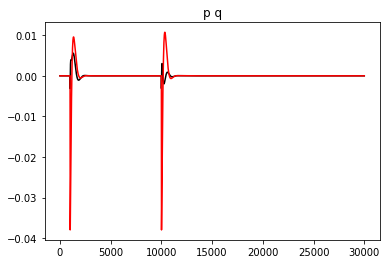

In [36]:
plt.plot(p,'k')
plt.plot(q,'r')
plt.title('p q')


Text(0.5, 1.0, 'phi theta')

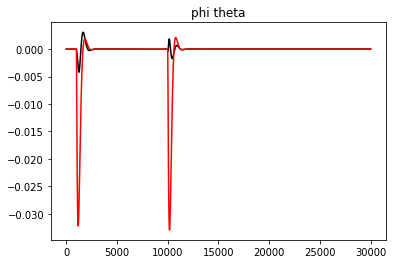

In [37]:
plt.plot(phi,'k')
plt.plot(theta,'r')
plt.title('phi theta')

Text(0.5, 1.0, 'd_lat d_lon d_col d_ped')

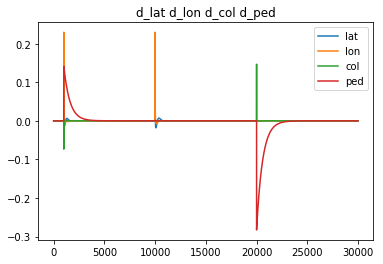

In [38]:
plt.plot(d_lat, label='lat')
plt.plot(d_lon, label='lon')
plt.plot(d_col, label='col')
plt.plot(d_ped, label='ped')
plt.legend()
plt.title('d_lat d_lon d_col d_ped')


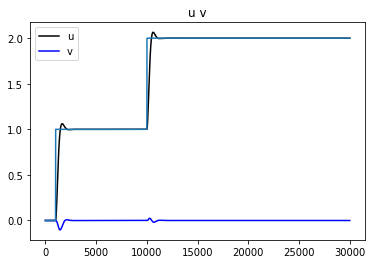

In [39]:
plt.plot(u,'k', label='u')
plt.plot(v,'b', label='v')
plt.title('u v')
plt.plot(u_ref)
plt.legend()

Text(0.5, 1.0, 'w')

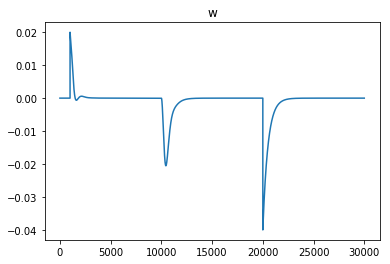

In [40]:
plt.plot(w)
plt.title('w')

Text(0.5, 1.0, 'z')

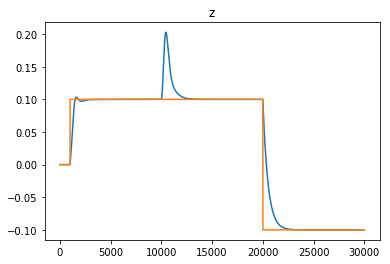

In [41]:
plt.plot(z)
plt.plot(z_ref)
plt.title('z')

Text(0.5, 1.0, 'psi')

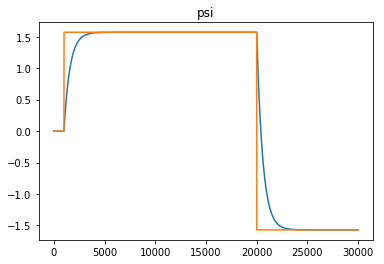

In [42]:
plt.plot(psi)
plt.plot(psi_ref)
plt.title('psi')

(-1.4094542497961013,
 29.598539245718126,
 -14.431830722092156,
 303.06752054007563)

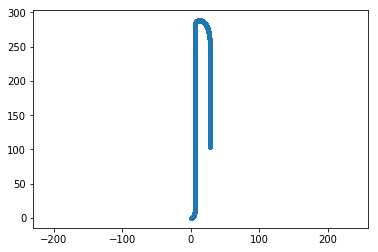

In [43]:
plt.plot(x,y,'.')
plt.axis('equal')